# Text Classification - Finding Cluster of Similar Document

## Requirements

Download the required packages to generate a model.

In [ ]:
# Install necessary libraries
!pip install pandas nltk scikit-learn gensim matplotlib seaborn

# Import libraries
import re
import unicodedata
import nltk
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

# Download NLTK data (stopwords)
nltk.download('stopwords')

## Import Data

Get a sample list of texts to compare between for similarities.


In [79]:
# Example text data
texts = [
    "Machine learning is a field of artificial intelligence that uses algorithms to learn from data.",
    "Natural Language Processing (NLP) is a subfield of linguistics and AI focused on the interaction between computers and human languages.",
    "Deep learning uses neural networks to model complex patterns in large amounts of data, such as images and text.",
    "Data science involves the extraction of knowledge and insights from structured and unstructured data.",
    "Computer vision is a field of AI that trains computers to interpret and understand the visual world.",
    "Data preprocessing is a crucial step in machine learning and NLP workflows, involving cleaning and transforming data.",
    "Supervised learning is a type of machine learning where a model is trained on labeled data.",
    "Unsupervised learning finds hidden patterns or intrinsic structures in data without labeled examples."
]

# Display the dataset
# Display the cleaned dataset
print(pd.DataFrame(texts, columns = ["Text"], index=[f'Doc {i+1}' for i in range(len(texts))]))

                                                    Text
Doc 1  Machine learning is a field of artificial inte...
Doc 2  Natural Language Processing (NLP) is a subfiel...
Doc 3  Deep learning uses neural networks to model co...
Doc 4  Data science involves the extraction of knowle...
Doc 5  Computer vision is a field of AI that trains c...
Doc 6  Data preprocessing is a crucial step in machin...
Doc 7  Supervised learning is a type of machine learn...
Doc 8  Unsupervised learning finds hidden patterns or...


## Text Cleaning

Preparing and standardizing text by removing noise, making it easier to analyze and compare.

1. Remove HTML Tags: Using regex to strip out any HTML tags.
2. Remove Accents: Converts accented characters to their base form using Unicode normalization.
3. Expand Contractions: Common contractions (e.g., "don't" → "do not") are expanded.
4. Remove Special Characters and Digits: Non-alphabetic characters and numbers are removed.
5. Lowercase: Converts all text to lowercase.
6. Stop Word Removal: Filters out common stop words using NLTK's stopwords list.

In [89]:
def clean_text(text):
    # 1. Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # 2. Remove accents
    text = ''.join([unicodedata.normalize('NFD', c).encode('ascii', 'ignore').decode('utf-8') for c in text])

    # 3. Remove contractions (for example: don't -> do not)
    contractions = {
        "don't": "do not", "didn't": "did not", "can't": "cannot", "couldn't": "could not",
        "won't": "will not", "isn't": "is not", "aren't": "are not", "wasn't": "was not",
        "weren't": "were not", "hasn't": "has not", "haven't": "have not", "hadn't": "had not"
    }
    for contraction, replacement in contractions.items():
        text = text.replace(contraction, replacement)

    # 4. Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 5. Convert to lowercase
    text = text.lower()

    # 6. Tokenize and remove stopwords
    wpt = nltk.WordPunctTokenizer()
    tokens = wpt.tokenize(text)

    stop_words = set(stopwords.words('english'))
    text_tokens = text.split()
    text_tokens = [word for word in text_tokens if word not in stop_words]
    return ' '.join(text_tokens)

# Clean the text
cleaned_texts = [clean_text(text) for text in texts]

# Display the cleaned dataset
print(pd.DataFrame(cleaned_texts, columns = ["Text"], index=[f'Doc {i+1}' for i in range(len(cleaned_texts))]))

                                                    Text
Doc 1  machine learning field artificial intelligence...
Doc 2  natural language processing nlp subfield lingu...
Doc 3  deep learning uses neural networks model compl...
Doc 4  data science involves extraction knowledge ins...
Doc 5  computer vision field ai trains computers inte...
Doc 6  data preprocessing crucial step machine learni...
Doc 7  supervised learning type machine learning mode...
Doc 8  unsupervised learning finds hidden patterns in...


## Feature Extraction
Converting text into numerical representations that capture the content and structure of the documents, enabling quantitative analysis.

1. Bag-of-Words (BoW): This converts text into a matrix of token counts.
2. Bag-of-Ngrams (2-grams): Instead of just words, this looks at pairs of consecutive words to capture more context.
3. TF-IDF: It calculates the importance of each word relative to the documents in the corpus.
4. Topic Modeling (LDA): Uses Latent Dirichlet Allocation to model topics in the text.


In [80]:
# 1. Bag-of-Words (BoW)
vectorizer_bow = CountVectorizer()
X_bow = vectorizer_bow.fit_transform(cleaned_texts) # show document feature vectors
headers = vectorizer_bow.get_feature_names_out()
print(pd.DataFrame(X_bow.toarray(), columns=headers,
                   index=[f'Doc {i+1}' for i in range(X_bow.shape[0])]))

       ai  algorithms  amounts  artificial  cleaning  complex  computer  \
Doc 1   0           1        0           1         0        0         0   
Doc 2   1           0        0           0         0        0         0   
Doc 3   0           0        1           0         0        1         0   
Doc 4   0           0        0           0         0        0         0   
Doc 5   1           0        0           0         0        0         1   
Doc 6   0           0        0           0         1        0         0   
Doc 7   0           0        0           0         0        0         0   
Doc 8   0           0        0           0         0        0         0   

       computers  crucial  data  ...  type  understand  unstructured  \
Doc 1          0        0     1  ...     0           0             0   
Doc 2          1        0     0  ...     0           0             0   
Doc 3          0        0     1  ...     0           0             0   
Doc 4          0        0     2  ...

In [82]:
# 2. Bag-of-Ngrams (2-grams)
vectorizer_ngram = CountVectorizer(ngram_range=(2, 2))
X_ngram = vectorizer_ngram.fit_transform(cleaned_texts)
headers = vectorizer_ngram.get_feature_names_out()
print(pd.DataFrame(X_ngram.toarray(), columns=headers,
                   index=[f'Doc {i+1}' for i in range(X_bow.shape[0])]))

       ai focused  ai trains  algorithms learn  amounts data  \
Doc 1           0          0                 1             0   
Doc 2           1          0                 0             0   
Doc 3           0          0                 0             1   
Doc 4           0          0                 0             0   
Doc 5           0          1                 0             0   
Doc 6           0          0                 0             0   
Doc 7           0          0                 0             0   
Doc 8           0          0                 0             0   

       artificial intelligence  cleaning transforming  complex patterns  \
Doc 1                        1                      0                 0   
Doc 2                        0                      0                 0   
Doc 3                        0                      0                 1   
Doc 4                        0                      0                 0   
Doc 5                        0                  

In [81]:
# 3. TF-IDF
vectorizer_tfidf = TfidfVectorizer()
X_tfidf = vectorizer_tfidf.fit_transform(cleaned_texts)
headers = vectorizer_tfidf.get_feature_names_out()
print(pd.DataFrame(X_tfidf.toarray(), columns=headers,
                   index=[f'Doc {i+1}' for i in range(X_bow.shape[0])]))

             ai  algorithms   amounts  artificial  cleaning   complex  \
Doc 1  0.000000    0.392459  0.000000    0.392459  0.000000  0.000000   
Doc 2  0.251469    0.000000  0.000000    0.000000  0.000000  0.000000   
Doc 3  0.000000    0.000000  0.306112    0.000000  0.000000  0.306112   
Doc 4  0.000000    0.000000  0.000000    0.000000  0.000000  0.000000   
Doc 5  0.277711    0.000000  0.000000    0.000000  0.000000  0.000000   
Doc 6  0.000000    0.000000  0.000000    0.000000  0.323775  0.000000   
Doc 7  0.000000    0.000000  0.000000    0.000000  0.000000  0.000000   
Doc 8  0.000000    0.000000  0.000000    0.000000  0.000000  0.000000   

       computer  computers   crucial      data  ...     type  understand  \
Doc 1  0.000000   0.000000  0.000000  0.196116  ...  0.00000    0.000000   
Doc 2  0.000000   0.251469  0.000000  0.000000  ...  0.00000    0.000000   
Doc 3  0.000000   0.000000  0.000000  0.152967  ...  0.00000    0.000000   
Doc 4  0.000000   0.000000  0.000000  

In [83]:
# 4. Topic Modeling (LDA)
lda = LatentDirichletAllocation(n_components=2, random_state=42)
X_topic = lda.fit_transform(X_tfidf)
headers = lda.get_feature_names_out()
print(pd.DataFrame(X_topic, columns=headers,
                   index=[f'Doc {i+1}' for i in range(X_bow.shape[0])]))

       latentdirichletallocation0  latentdirichletallocation1
Doc 1                    0.811999                    0.188001
Doc 2                    0.860799                    0.139201
Doc 3                    0.135245                    0.864755
Doc 4                    0.847499                    0.152501
Doc 5                    0.150076                    0.849924
Doc 6                    0.143661                    0.856339
Doc 7                    0.160921                    0.839079
Doc 8                    0.847926                    0.152074


## Measure Similarity
Quantifying how similar documents are to one another, which is essential for tasks like clustering or identifying related documents.

**Cosine Similarity:** Measuring how alike documents are based on their vector representations, useful for finding related documents.

In [88]:
# Cosine similarity between documents (using BoW as an example)
similarity_matrix = cosine_similarity(X_bow)

# Display the similarity matrix
print("Cosine Similarity Matrix (BoW):")
print(pd.DataFrame(similarity_matrix))

Cosine Similarity Matrix (BoW):
          0         1         2         3         4         5         6  \
0  1.000000  0.000000  0.277350  0.201008  0.105409  0.356348  0.402015   
1  0.000000  1.000000  0.000000  0.000000  0.182574  0.077152  0.000000   
2  0.277350  0.000000  1.000000  0.167248  0.000000  0.222375  0.334497   
3  0.201008  0.000000  0.167248  1.000000  0.000000  0.322329  0.181818   
4  0.105409  0.182574  0.000000  0.000000  1.000000  0.000000  0.000000   
5  0.356348  0.077152  0.222375  0.322329  0.000000  1.000000  0.402911   
6  0.402015  0.000000  0.334497  0.181818  0.000000  0.402911  1.000000   
7  0.201008  0.000000  0.250873  0.181818  0.000000  0.241747  0.363636   

          7  
0  0.201008  
1  0.000000  
2  0.250873  
3  0.181818  
4  0.000000  
5  0.241747  
6  0.363636  
7  1.000000  


## Clustering and Dendrogram

**Hierarchical Clustering and Dendrograms:** Groups similar documents into clusters, visualizing relationships based on topic similarity.

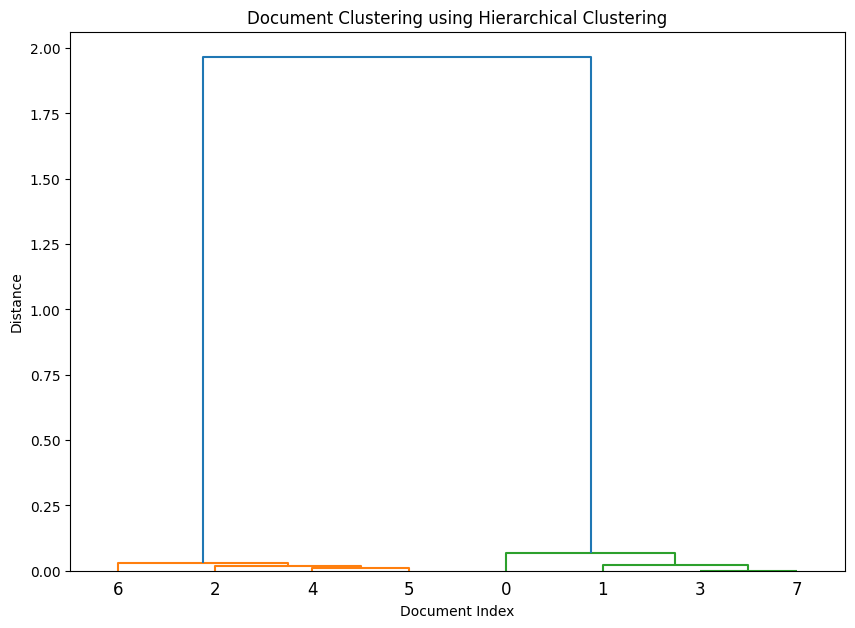

In [78]:
# Hierarchical clustering on topic model features
Z = linkage(X_topic, method='ward')

# Plot Dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title("Document Clustering using Hierarchical Clustering")
plt.xlabel("Document Index")
plt.ylabel("Distance")
plt.show()

## Conclusion and Analysis

This dendrogram shows the hierarchical clustering of documents based on their feature similarity.

### Key Components:
- **Document Index**: The x-axis represents each document by its index each referring to one of the text respectly (i.e. 0 is Document 1, 1 is Document 2, etc.).
- **Distance**: The y-axis shows the "distance" (or dissimilarity) between clusters, with larger distances indicating less similarity.
- **Linkages**: Each merge or branch point represents a step in the hierarchical clustering process where two clusters are combined based on their similarity.

### Interpretation:
- **Cluster Formation**: Documents that are closer together on the x-axis and merge at lower points on the y-axis are more similar to each other. For example, documents at indices 4 and 5 are very similar to each other followed by 2 and 6. Similarly, documents at indices 3 and 7 are very similar to each other followed by 0 and 1. Both clusters viewed separately have low y-value, indicating high similarity.
- **Main Clusters**: At a high y-value (around 2.0), there's a large split between two main clusters. This means there are two major groups of documents that are quite different from each other.

This plot helps visualize which documents are more similar and how they can be grouped based on content or topics. The height of each linkage reveals the similarity level required to merge documents or clusters.